In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [3]:
train=pd.read_csv('input/train.csv', index_col=0)#, na_values='?') #인덱스 col=0도 check!
test=pd.read_csv('input/test.csv', index_col=0)#, na_values='?')
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [4]:
train['income']=pd.factorize(train['income'], sort=True)[0]

In [ ]:
train.shape, test.shape

In [ ]:
train.head(3)
test.head(3)

# 2. EDA & 전처리

In [ ]:
train.info()
train.describe()
train.describe(include='O')

## Missing Value

In [ ]:
train.isnull().sum()#.sum()
test.isnull().sum()#.sum()

### outlier

### education

In [5]:
train.drop(['education'],axis=1, inplace=True)
test.drop(['education'],axis=1, inplace=True)

### capital_gain 99999

In [6]:
df = pd.concat([train, test])
df.shape

(32561, 14)

In [7]:
df['capital_gain_imsi'] = df['capital_gain'].replace(99999,0)

In [8]:
capital_gain_imsi = pd.DataFrame(df.groupby(['education_num'])['capital_gain_imsi'].mean()).reset_index()

In [9]:
train = train.merge(capital_gain_imsi, on=['education_num'], how='left')
test = test.merge(capital_gain_imsi, on=['education_num'], how='left')

In [10]:
train.loc[train.capital_gain == 99999, 'capital_gain'] = train['capital_gain_imsi']
test.loc[test.capital_gain == 99999, 'capital_gain'] = test['capital_gain_imsi']

In [11]:
train.drop(['capital_gain_imsi'],axis=1, inplace=True)
test.drop(['capital_gain_imsi'],axis=1, inplace=True)

In [12]:
train['imsi'] = train.capital_gain*train.hours_per_week#*train.capital_loss
test['imsi'] = test.capital_gain*test.hours_per_week#*train.capital_loss

In [13]:
train['imsi2'] = train.age*train.education_num#*train.capital_loss
test['imsi2'] = test.age*test.education_num#*train.capital_loss

# 3. 모델 학습

In [ ]:
import gc
gc.collect()

In [ ]:
train.columns

In [14]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'income'
          #, categorical_features=col_cat
          , numeric_features = ['education_num']
          , ignore_features =['age','fnlwgt']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(26049, 16)"
4,Missing Values,False
5,Numeric Features,8
6,Categorical Features,7
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 24.4 s


In [15]:
best_3 = compare_models(sort = 'F1', n_select = 3
                       ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.8648,0.9228,0.6303,0.7699,0.6929,0.6073,0.6125,23.9482
1,Extreme Gradient Boosting,0.8635,0.9209,0.6355,0.7613,0.6925,0.6058,0.6100,7.5549
2,Light Gradient Boosting Machine,0.8630,0.9209,0.6364,0.7590,0.6921,0.6049,0.6090,1.2209
3,Gradient Boosting Classifier,0.8608,0.9166,0.6154,0.7641,0.6814,0.5938,0.5996,8.2789
4,Ada Boost Classifier,0.8550,0.9099,0.6183,0.7414,0.6736,0.5814,0.5859,3.1337
5,Linear Discriminant Analysis,0.8456,0.9000,0.5901,0.7215,0.6489,0.5512,0.5560,0.5770
6,Random Forest Classifier,0.8390,0.8706,0.5801,0.7034,0.6355,0.5334,0.5377,0.2469
7,Extra Trees Classifier,0.8291,0.8545,0.5992,0.6630,0.6292,0.5186,0.5199,1.1595


In [16]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8672,0.9202,0.6311,0.7784,0.6971,0.6132,0.6187
1,0.8590,0.9148,0.6408,0.7416,0.6875,0.5971,0.5997
2,0.8586,0.9223,0.6149,0.7555,0.6780,0.5886,0.5937
3,0.8715,0.9296,0.6353,0.7919,0.7050,0.6241,0.6303
4,0.8703,0.9227,0.6489,0.7786,0.7079,0.6254,0.6297
Mean,0.8653,0.9219,0.6342,0.7692,0.6951,0.6097,0.6144
SD,0.0055,0.0048,0.0113,0.0181,0.0111,0.0146,0.0152


In [17]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8739,0.9282,0.6548,0.7882,0.7153,0.6352,0.6397


In [18]:
%%time
final_model = finalize_model(blended)

Wall time: 3min 33s


In [19]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [20]:
submission['prediction'] = predictions['Label']

# 5. 제출

In [21]:
submission.to_csv('output/20201024-3.csv')

In [22]:
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8567,0.9183,0.6117,0.7500,0.6738,0.5832,0.5882
1,0.8543,0.9130,0.6149,0.7393,0.6714,0.5788,0.5829
2,0.8630,0.9196,0.6570,0.7463,0.6988,0.6106,0.6126
3,0.8542,0.9131,0.6136,0.7383,0.6702,0.5777,0.5817
4,0.8542,0.9129,0.6246,0.7338,0.6748,0.5817,0.5848
5,0.8723,0.9317,0.6472,0.7874,0.7105,0.6295,0.6345
6,0.8770,0.9364,0.6537,0.8016,0.7201,0.6423,0.6478
7,0.8574,0.9188,0.6019,0.7592,0.6715,0.5819,0.5883
8,0.8699,0.9250,0.6472,0.7782,0.7067,0.6240,0.6284
9,0.8762,0.9207,0.6828,0.7786,0.7276,0.6479,0.6502


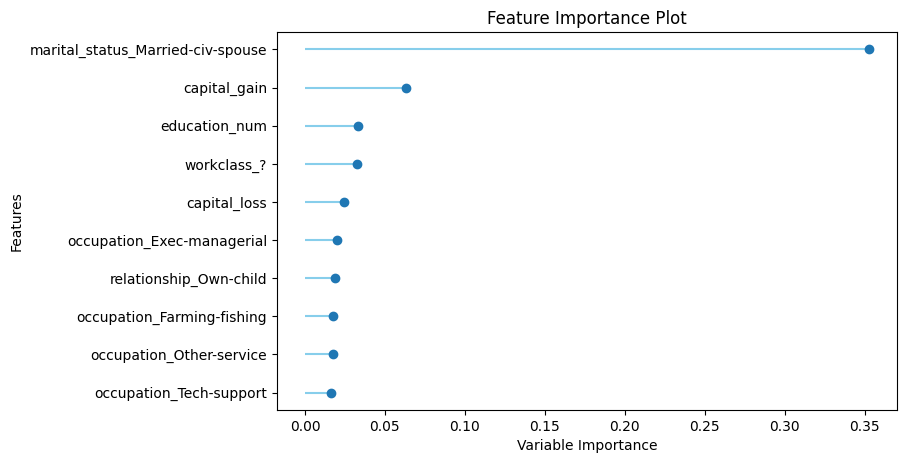

In [23]:
plot_model(estimator = xgboost, plot = 'feature')

In [24]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8598,0.9175,0.6084,0.7642,0.6775,0.5894,0.5957
1,0.8622,0.9166,0.6537,0.7454,0.6966,0.6079,0.6101
2,0.8653,0.9206,0.6764,0.7438,0.7085,0.6212,0.6223
3,0.8495,0.9122,0.6039,0.7266,0.6596,0.5640,0.5680
4,0.8550,0.9137,0.6117,0.7441,0.6714,0.5795,0.5841
5,0.8629,0.9316,0.6278,0.7638,0.6892,0.6023,0.6070
6,0.8801,0.9362,0.6602,0.8095,0.7273,0.6514,0.6570
7,0.8605,0.9178,0.6246,0.7569,0.6844,0.5959,0.6004
8,0.8597,0.9221,0.6246,0.7539,0.6832,0.5941,0.5985
9,0.8754,0.9208,0.6731,0.7820,0.7235,0.6436,0.6466


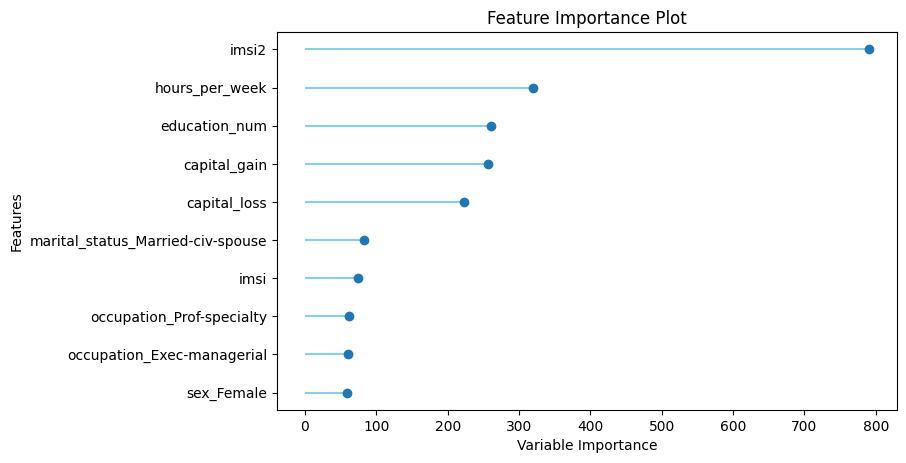

In [25]:
plot_model(estimator = lightgbm, plot = 'feature')